Домашнее задание по результатам 3 вебинара.  

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции   
 y = sin(x)x - x10  
При выполнении данного задания структура GAN остается той же, но Вам нужно:  
Сгенерировать настоящие данные  
Изменить архитектуру дискриминатора и генератора  
Без графиков домашку не принимаю  
(*Усложненное задание) Используя датасет MNIST из урока, построить модели генератора и дискриминатора в модели DCGAN как описано в оригинальной статье. И обучите ее на данных MNIST. В качестве помощи, можете воспользоваться официальной статьей от pytorch. 

In [1]:

import numpy as np
import math

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt


In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
def f(x):
    return np.sin(x)*x-10*x


In [4]:
x = np.linspace(-100,100,1000000)
y = f(x)
data = np.column_stack((x,y))
data.shape

(1000000, 2)

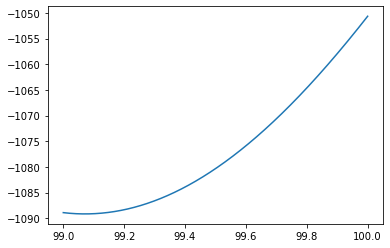

In [5]:

plt.plot(data[-5000:-1,0],data[-5000:-1,1])
plt.show()

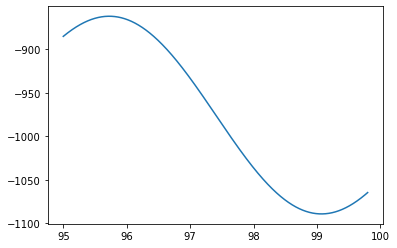

In [6]:

plt.plot(data[-25000:-1000,0],data[-25000:-1000,1])
plt.show()

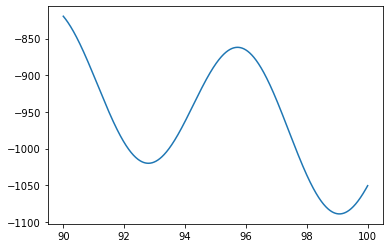

In [7]:

plt.plot(data[-50000:-1,0],data[-50000:-1,1])
plt.show()

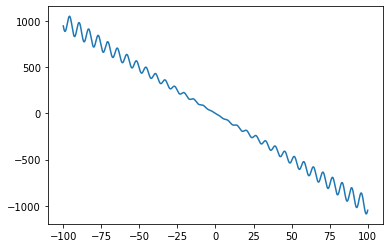

In [8]:

plt.plot(data[:,0],data[:,1])
plt.show()

In [9]:
data.shape

(1000000, 2)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, x):
        self.data_info = x
        self.data_len = len(self.data_info)
        
    def __getitem__(self, index):
        x= self.data_info[index]
        return (x)

    def __len__(self):
        return self.data_len

In [11]:
train_data = CustomDataset(data)


In [12]:
train_data_loader = DataLoader(train_data,batch_size=1000,shuffle=True)


In [13]:
sample = iter(train_data_loader).next()

In [14]:
sample.shape

torch.Size([1000, 2])

In [15]:
class Generator(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)],
                ['sigmoid',nn.Sigmoid()]])
        
        Liner = nn.Linear
        self.model = nn.Sequential(
                        Liner(latent_dim,256),
                        nn.Dropout(0.2),
                        nn.BatchNorm1d(256),
                        activations['sigmoid'],
                        Liner(256,512),
                        nn.Dropout(0.2),
                        nn.BatchNorm1d(512),
                        activations['relu'],
                        Liner(512,1024),
                        nn.Dropout(0.3),
                        nn.BatchNorm1d(1024),
                        activations['relu'],
                        Liner(1024,2048),
                        nn.Dropout(0.4),
                        nn.BatchNorm1d(2048),
                        activations['relu'],
                        Liner(2048,2)
                                    )

    def forward(self, z):
        data = self.model(z)
        return data

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)],
                ['sigmoid',nn.Sigmoid()]])
        
        Liner = nn.Linear
        
        self.model = nn.Sequential(
            Liner(2, 512),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512),
            activations['sigmoid'],
            Liner(512, 1024),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),
            activations['lrelu'],
            Liner(1024, 512),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            activations['lrelu'],
            Liner(512, 1),  
            activations['sigmoid'],
        )
  

    def forward(self, z):
        validity = self.model(z)
        return validity

In [17]:
n_epochs = 15 # количество эпох
lr = 0.0005 # шаг обучения
# b1 = 0.5 # гиперпараметр для оптимайзера Adam
# b2 = 0.999 # гиперпараметр для оптимайзера Adam
latent_dim = 50 # Размерность случайного вектора, который подается на вход генератору


In [18]:
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)


# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [19]:
d_loss_history = []
g_loss_history = []

In [20]:
for epoch in range(n_epochs):
    for i, x_data in enumerate(train_data_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        batch_size = x_data.size(0)
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_data = x_data.type(torch.FloatTensor).to(device)
        
######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_data.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
    pred = gen_data.cpu()
    pred = pred.detach().numpy()
    mae = np.mean(np.abs(pred[:,1]-f(pred[:,0])))       
    err = np.mean(np.abs(pred[:,1]-f(pred[:,0]))/np.abs(f(pred[:,0])))
    
    print(f'Эпоха: {epoch},d_loss: {d_loss}, g_loss {g_loss},mae:{mae},относительная абс. ошибка: {err} ')

Эпоха: 0,d_loss: 0.2820747196674347, g_loss 2.361130475997925,mae:11.343246459960938,относительная абс. ошибка: 0.24119946360588074 
Эпоха: 1,d_loss: 0.0914541482925415, g_loss 3.385540008544922,mae:23.0674991607666,относительная абс. ошибка: 0.11775322258472443 
Эпоха: 2,d_loss: 0.13699425756931305, g_loss 3.381492853164673,mae:41.9613151550293,относительная абс. ошибка: 0.1390894055366516 
Эпоха: 3,d_loss: 0.6115590929985046, g_loss 1.2771577835083008,mae:35.686927795410156,относительная абс. ошибка: 0.09996593743562698 
Эпоха: 4,d_loss: 0.8454341292381287, g_loss 0.580609142780304,mae:48.3664436340332,относительная абс. ошибка: 0.39155685901641846 
Эпоха: 5,d_loss: 0.7891095280647278, g_loss 0.6308048963546753,mae:40.63960266113281,относительная абс. ошибка: 0.16501650214195251 
Эпоха: 6,d_loss: 0.642936646938324, g_loss 0.8917338848114014,mae:56.1661491394043,относительная абс. ошибка: 0.17036627233028412 
Эпоха: 7,d_loss: 0.684339165687561, g_loss 0.721408486366272,mae:44.08438110

In [21]:
z = torch.FloatTensor(np.random.normal(0, 1, (100, latent_dim))).to(device)

In [22]:
pred = generator(z).cpu()
pred = pred.detach().numpy()

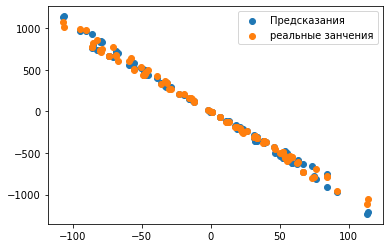

In [23]:
plt.scatter(pred[:,0],pred[:,1],label='Предсказания')
plt.scatter(pred[:,0],f(pred[:,0]), label = 'реальные занчения')
plt.legend()
plt.show()

In [24]:
# Средняя относительная абсолютная ощибка
err = np.mean(np.abs(pred[:,1]-f(pred[:,0]))/np.abs(f(pred[:,0])))
err

0.09307036

Вторая часть

In [203]:
img_size = 64 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 512 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки

real_data = DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=False,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,num_workers=2
)

img_shape = (1, 64, 64)
lable_shape = torch.Size([])
img_shape after squeeze = (64, 64)
Значения: tensor([1, 5, 3])


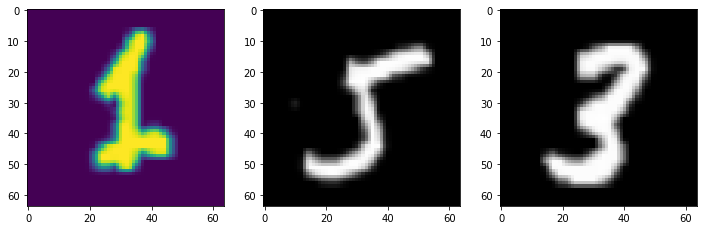

In [204]:
dataiter = iter(real_data)
images, labels = dataiter.next()
images = images.numpy()

print(f'img_shape = {images[0].shape}')
print(f'lable_shape = {labels[0].size()}')

# np.squeeze - позволяет избавиться от размерности где равно 1 в тензоре
img = np.squeeze(images[0])
print(f'img_shape after squeeze = {img.shape}')

img1 = np.squeeze(images[1])
img2 = np.squeeze(images[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
ax1.imshow(img)
ax2.imshow(img1, cmap='gray')
ax3.imshow(img2, cmap='gray')
print(f'Значения: {labels[:3]}')

In [205]:
import torchvision.utils as vutils

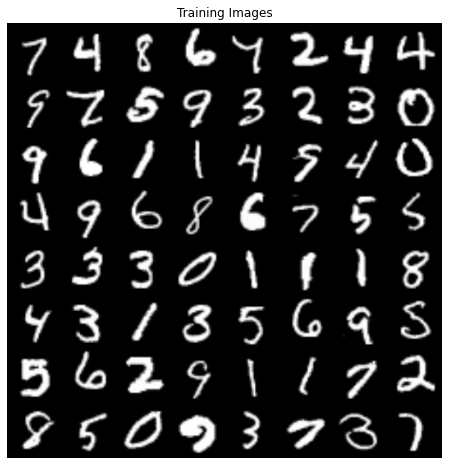

In [206]:
real_batch = dataiter.next()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [207]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [208]:

class GeneratorDCGAN(nn.Module):
    def __init__(self,nz,ngf,nc):
        super(GeneratorDCGAN, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution nz*1*1
            nn.ConvTranspose2d( in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0,bias=False),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.ReLU(inplace = True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels= ngf * 4, kernel_size =4, stride =  2,padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.ReLU(inplace = True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 2),
            nn.ReLU(inplace = True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels= ngf * 2, out_channels =ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf),
            nn.ReLU(inplace = True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( in_channels = ngf, out_channels = nc, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [209]:
param_gen={'nz':5,'ngf':128,'nc':1}
DCGAN_generator =GeneratorDCGAN (**param_gen).to(device)
DCGAN_generator.apply(weights_init)

GeneratorDCGAN(
  (main): Sequential(
    (0): ConvTranspose2d(5, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh

In [210]:
class DiscriminatorDCGAN(nn.Module):
    def __init__(self,nc,ngf):
        super(DiscriminatorDCGAN, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels = nc, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels = ngf, out_channels =ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 2),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels = ngf * 2, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 4),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels = ngf * 4, out_channels = ngf * 8,  kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(num_features = ngf * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels = ngf * 8, out_channels = 1, kernel_size = 4, stride = 1, padding = 0, bias=False),
#             получили скаляр
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [211]:
param_disc=param_gen.copy()
del param_disc['nz']
DCGAN_discriminator =DiscriminatorDCGAN (**param_disc).to(device)
DCGAN_discriminator.apply(weights_init)

DiscriminatorDCGAN(
  (main): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [212]:
lr = 0.0002
beta1 = 0.5
num_epochs = 5

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, param_gen['nz'], 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(DCGAN_discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(DCGAN_generator.parameters(), lr=lr, betas=(beta1, 0.999))


In [213]:
fixed_noise.shape

torch.Size([512, 5, 1, 1])

In [214]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(real_data, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        DCGAN_discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = DCGAN_discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, param_gen['nz'], 1, 1, device=device)
        # Generate fake image batch with G
        fake = DCGAN_generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = DCGAN_discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        DCGAN_generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = DCGAN_discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(real_data),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(real_data)-1)):
            with torch.no_grad():
                fake = DCGAN_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/118]	Loss_D: 2.4704	Loss_G: 14.6070	D(x): 0.4604	D(G(z)): 0.6492 / 0.0009
[1/5][0/118]	Loss_D: 0.4019	Loss_G: 6.4907	D(x): 0.9563	D(G(z)): 0.2600 / 0.0034
[2/5][0/118]	Loss_D: 1.1183	Loss_G: 3.7138	D(x): 0.8823	D(G(z)): 0.5301 / 0.0518
[3/5][0/118]	Loss_D: 1.0525	Loss_G: 1.3456	D(x): 0.4803	D(G(z)): 0.0674 / 0.3256
[4/5][0/118]	Loss_D: 0.9183	Loss_G: 1.2845	D(x): 0.5391	D(G(z)): 0.1301 / 0.3234


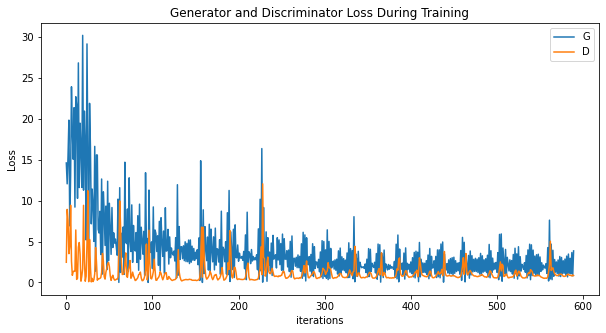

In [215]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [216]:
import matplotlib.animation as animation
from IPython.display import HTML

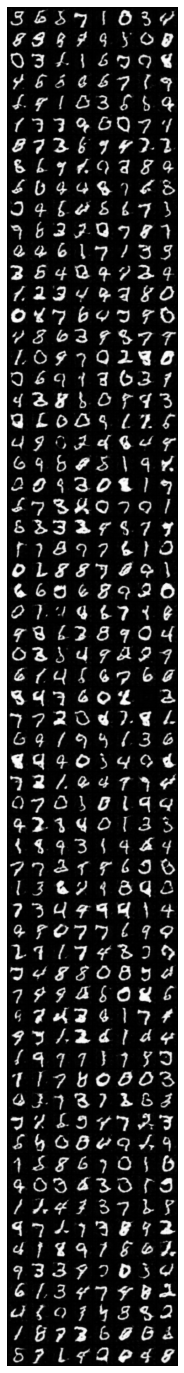

In [217]:
#%%capture
fig = plt.figure(figsize=(10,25))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [226]:
a =torch.randn(b_size, param_gen['nz'], 1, 1, device=device)

In [227]:
a.shape

torch.Size([96, 5, 1, 1])

In [236]:
z = DCGAN_generator(a)

In [237]:
z.shape

torch.Size([96, 1, 64, 64])

In [241]:
z1=z[5].permute(1,2,0).cpu()

In [242]:
z1 = z1.detach().numpy()

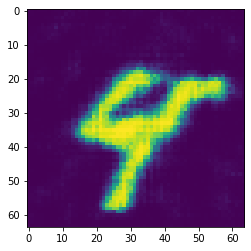

In [243]:
plt.imshow(z1)